### Packages

In [1]:
# !pip install -q 'gwosc==0.7.1'
import gwosc

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

# !pip install --upgrade gwpy
import gwpy

## 1. Filtering Events and Obtaining Events Information

### List of avaibale filters

Example: Find avaiable catalog filters
 - `find_datasets(type='catalog')`

 - type = 'run', 'event', or 'catalog' (str; type of datasets to restrict)

In [2]:
from gwosc.datasets import find_datasets
from gwosc import datasets

print("List of available catalogs")
print(find_datasets(type="catalog"))

List of available catalogs
['GWTC', 'GWTC-1-confident', 'GWTC-1-marginal', 'GWTC-2', 'GWTC-2.1-auxiliary', 'GWTC-2.1-confident', 'GWTC-2.1-marginal', 'GWTC-3-confident', 'GWTC-3-marginal', 'Initial_LIGO_Virgo', 'O1_O2-Preliminary', 'O3_Discovery_Papers', 'O3_IMBH_marginal', 'O4_Discovery_Papers']


In [3]:
print("List of available runs")
print(find_datasets(type="run"))

List of available runs
['BKGW170608_16KHZ_R1', 'O1', 'O1_16KHZ', 'O2_16KHZ_R1', 'O2_4KHZ_R1', 'O3GK_16KHZ_R1', 'O3GK_4KHZ_R1', 'O3a_16KHZ_R1', 'O3a_4KHZ_R1', 'O3b_16KHZ_R1', 'O3b_4KHZ_R1', 'S5', 'S6']


### Search for specific event using filter

Example: Find the events name in the catalog

 - `datasets.find_datasets(type='events', catalog='GWTC-1-confident')`


Filters are catorgorised by:
- detector = 'V1' (str; prefix of GW detector)

  *   'G1' - GEO600
  *   'H1' - LIGO-Hanford
  *   'L1' - LIGO-Livingston
  *   'V1' - (Advanced) Virgo
  *   'K1' - KAGRA

- type = 'run', 'event', or
'catalog' (str; type of datasets to restrict)
- segment = [ _start, stop_ ] (int; GPS time)
- match = '_keyword_' (str; expression string against which to match datasets)
- catalog = '_catalog_name_' (str; catalog filter)

In [4]:
gwtc1 = datasets.find_datasets(type='events', catalog='GWTC-1-confident')
print('GWTC-1 events:', gwtc1)
print("")

GWTC-1 events: ['GW150914-v3', 'GW151012-v3', 'GW151226-v2', 'GW170104-v2', 'GW170608-v3', 'GW170729-v1', 'GW170809-v1', 'GW170814-v3', 'GW170817-v3', 'GW170818-v1', 'GW170823-v1']



### Search for GPS time of a event

- `event_gps('GW190425')`

In [5]:
from gwosc.datasets import event_gps
gps = event_gps('GW190425')
print(gps)

1240215503.0


### Search for events at GPS time
- `time:datasets.event_at_gps(1240215503)`


In [6]:
from gwosc.datasets import event_at_gps
print(datasets.event_at_gps(1240215503))

GW190425


### Search for GPS time interval for a run

-   `run_segment('O1')`

In [7]:
from gwosc.datasets import run_segment
print(run_segment('O1'))

(1126051217, 1137254417)


### Search for runs in GPS time interval
- `run_at_gps(1240215503)`

In [8]:
from gwosc.datasets import run_at_gps
print(run_at_gps(1240215503))

O3a_4KHZ_R1


### Search for data file URL for an event with filters
- `get_event_urls('GW150914', duration=32, detector='L1')`

In [9]:
from gwosc.locate import get_event_urls
urls = get_event_urls('GW150914', duration=32, detector='L1')
print(urls)

['http://gwosc.org/eventapi/json/GWTC-1-confident/GW150914/v3/L-L1_GWOSC_4KHZ_R1-1126259447-32.hdf5']


### List of other adjustable filters by merger
- `query_events?`

In [10]:
from gwosc.datasets import query_events
query_events?

### Search for events using merger filters
- `query_events(select=["25 <= network-matched-filter-snr <= 30"])`

In [11]:
from gwosc.datasets import query_events
selection = query_events(select=["25 <= network-matched-filter-snr <= 30"])
#this is equivalent to
#query_events(select=["network-matched-filter-snr <= 30", "network-matched-filter-snr>= 25"])
print(selection)

['GW200129_065458-v1', 'GW190814-v1', 'GW190814_211039-v3', 'GW190521_074359-v2', 'GW150914-v3']


## 2. Fetching time and frequency series

### Fetch time series data of an event

- `TimeSeries.fetch_open_data('L1', *segment, verbose=True, cache=True)`

- `'L1'` : prefix of the IFO
- `*segment` : Start and end GPS time
- `verbose=True` : Display data loading process
- `cache=True` : Store the file on computer

Fetched 1 URLs from gwosc.org for [1239082257 .. 1239082267))
Reading data... [Done]


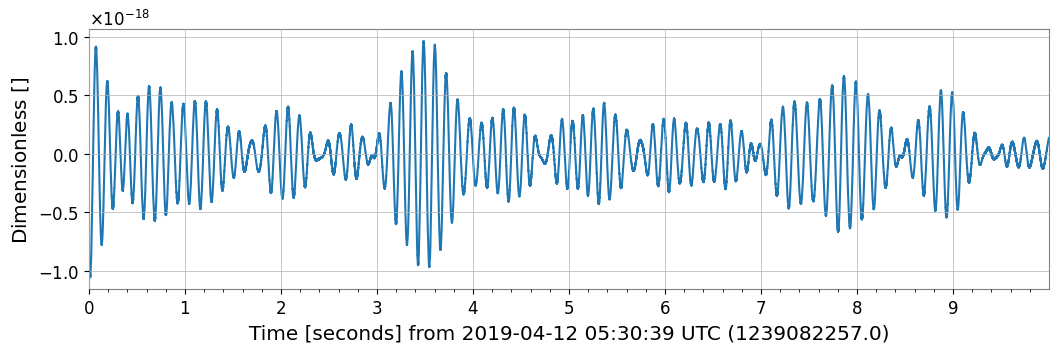

In [12]:
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries

# 1. Obtain GPS of event
gps = event_gps('GW190412')
# 2. Specify segment
segment = (int(gps)-5, int(gps)+5)
# 3. Save data
ldata = TimeSeries.fetch_open_data('L1', *segment, verbose=True, cache=True)
# 4. Plot data
plot = ldata.plot()

### Plotting frequency series from time series
- `data.fft()`

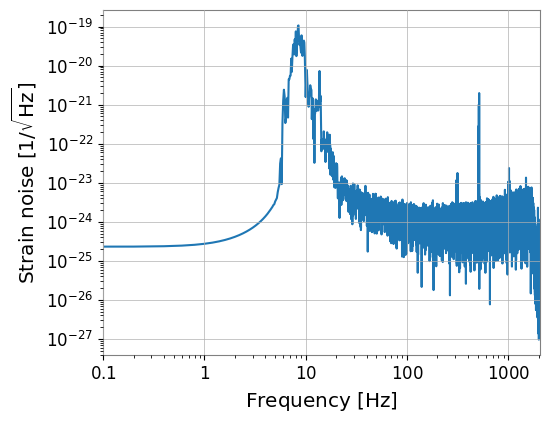

In [13]:
# 1. Remove edge of data to remove discontinuities when transformed
from scipy.signal import get_window
window = get_window('hann', ldata.size)
lwin = ldata * window
# 2. Obtain frequency series
fft = lwin.fft()
# 3. Obtain real amplitude
plot = fft.abs().plot(xscale="log", yscale="log")
# 4. Plot data
ax = plot.gca()
ax.set_ylabel(r'Strain noise [$1/\sqrt{\mathrm{Hz}}$]')
plot.show(warn=False)

## 3. Cleaning noise

Understanding source of noise
1. Random, dense fluctuations at frequencies larger than 10 Hz due to intrinsic noise in the estimate of the spectral content of the signal from a single FFT.

- **Solution: Power Spectral Density (PSD)**

  Averaging many estimates of the signal FFT. But, being the FFT components complex quantities, what we really want to average are their squared moduli.

- **Amplitude Spectral Density (ASD)**

   It is also convenient to express the result not as a power but as an amplitude, taking the square root of the above expression.

   Alternatively, one could have combined the various FFT estimates calculating their median, which is a more robust statistic than the mean implemented in Welch's method with respect to spurious fluctuations of the signal level.

### Obtain the ASD plot

- `data.asd(fftlength=2, method="median")`

- `fftlength=2` : duration in seconds of the data used to estimate each FFT
- `method="median"` : method used to average the data ('median' or 'welch')

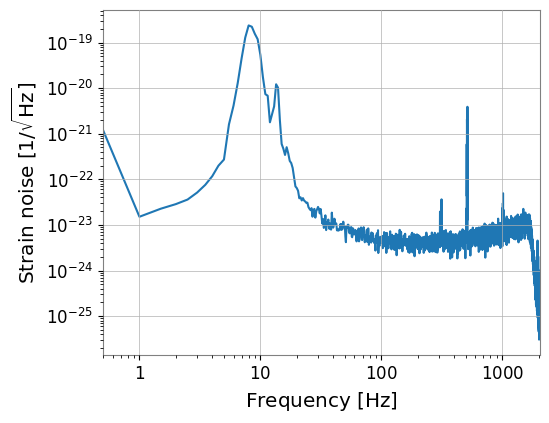

In [14]:
asd = ldata.asd(fftlength=2, method="median")
plot = asd.plot()
ax = plot.gca()
ax.set_ylabel(r'Strain noise [$1/\sqrt{\mathrm{Hz}}$]')
plot.show(warn=False)

### Seeing more details in ASD plot
Loading more data allows for more FFTs to be averaged during the ASD estimation, meaning random variations get averaged out, and we can see more detail.

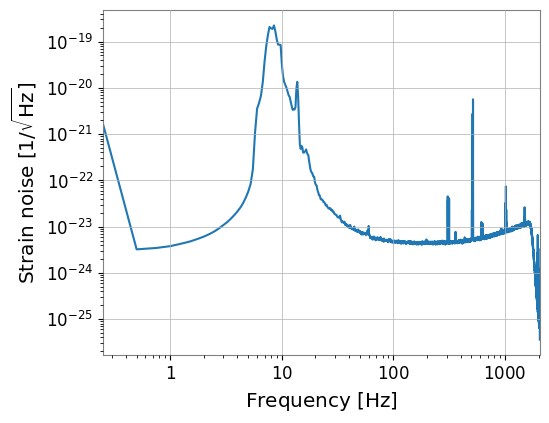

In [15]:
# Load data with larger time interval (512 x 2)
ldata2 = TimeSeries.fetch_open_data('L1', int(gps)-512, int(gps)+512, cache=True)
lasd2 = ldata2.asd(fftlength=4, method="median")
plot = lasd2.plot()
ax = plot.gca()
ax.set_ylabel(r'Strain noise [$1/\sqrt{\mathrm{Hz}}$]')
plot.show(warn=False)

### Compare LIGO-Hanford and Virgo ASD plots

In [16]:
# get Hanford data
hdata2 = TimeSeries.fetch_open_data('H1', int(gps)-512, int(gps)+512, cache=True)
hasd2 = hdata2.asd(fftlength=4, method="median")

# get Virgo data
vdata2 = TimeSeries.fetch_open_data('V1', int(gps)-512, int(gps)+512, cache=True)
vasd2 = vdata2.asd(fftlength=4, method="median")

# and plot using standard colours
ax.plot(hasd2, label='LIGO-Hanford', color='gwpy:ligo-hanford')
ax.plot(vasd2, label='Virgo', color='gwpy:virgo')

# update the Livingston line to use standard colour, and have a label
lline = ax.lines[0]
lline.set_color('gwpy:ligo-livingston')  # change colour of Livingston data
lline.set_label('LIGO-Livingston')

ax.set_ylabel(r'Strain noise [$1/\sqrt{\mathrm{Hz}}$]')
ax.legend()
plot.show(warn=False)